<a href="https://colab.research.google.com/github/shakhovak/Study-projects-in-Uni/blob/main/shakhova_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 1 Нахождение похожих товаров в интернет-магазинах по их описанию.

**ПРИМЕРНЫЙ ПЛАН ВЫПОЛНЕНИЯ ПРОЕКТА:**

- Представьте массив текстов в виде векторов (как с помощью TF-IDF, так и с помощью Word2Vec).
- Выберите расстояние, с помощью которого вы будете оценивать близость векторов, представляющих тексты (рекомендуется использовать косинусное расстояние, но вы можете попробовать и другие подходы).Для полученных векторов попарно найдите косинусное расстояние (попробуйте сделать это без цикла, с помощью матричных операций).
- Задайте какой-то порог значимости (с которым вы сравните значения расстояния между векторами), на основе которого вы будете судить о том, похожи два текста или нет.


## 1. EDA
Посмотрим на исходные описания товаров:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data/sample-data.csv', index_col = 'id')
df

,description
id,
1,Active classic boxers - There's a reason why o...
2,Active sport boxer briefs - Skinning up Glory ...
3,Active sport briefs - These superbreathable no...
4,"Alpine guide pants - Skin in, climb ice, switc..."
5,"Alpine wind jkt - On high ridges, steep ice an..."
...,...
496,Cap 2 bottoms - Cut loose from the maddening c...
497,Cap 2 crew - This crew takes the edge off fick...
498,All-time shell - No need to use that morning T...


In [4]:
list(df.iloc[100:101]['description'])

['Pataloha shirt - Early Hawaiian shirts were pitched as "postcards you can wear." We\'ve been making ours  inspired by native designs true to the aloha spirit  for 20 years. Exquisitely tailored in environmentally friendly 3.3-oz 100% organic cotton coconut cloth, their textured cloth, cools in humid climates. Coconut buttons and chest pocket. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>100% organic cotton coconut-weave fabric</li> <li>Chest pocket</li> <li>Coconut buttons</li></ul><br><br><b>Fabric: </b>3.3-oz 100% organic cotton coconut cloth. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(222 g 7.7 oz)<br><br>Made in Thailand.']

Очевидно, что в тексте много лишних знаков. Обработаем тексты с помощью функции ниже:

- удалим весь текст в треугольных скобках
- удалим все знаки кроме букв и слов
- токенизируем текст
- приведем все слова в нормальную форму
- удалим стоп-слова

In [5]:
from nltk.stem import WordNetLemmatizer
import string
import nltk
import re
import warnings
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def tokenize(series):

    texts = []

    for ind, text in series.items():

        text_lower = text.lower()
        text_lower = re.sub(re.compile('\<(.*?)\>'), '', text_lower).strip()
        text_lower = re.sub(re.compile('[^\w\s]'), ' ', text_lower).strip()
        tokens = word_tokenize(text_lower)
        tokens = [lemmatizer.lemmatize(nltk.pos_tag([word])[0][0],\
                                       pos = nltk_pos_tagger(nltk.pos_tag([word])[0][1])) for word in tokens]
        tokens = [word for word in tokens if(word not in stop_words)]
        texts.append(tokens)

    return texts

In [7]:
token_texts = tokenize(df['description'])

Посмотрим на длину текстов, чтобы определиться с длиной векторов для Word2Vec. В принципе длина в 250 будет достаточной.

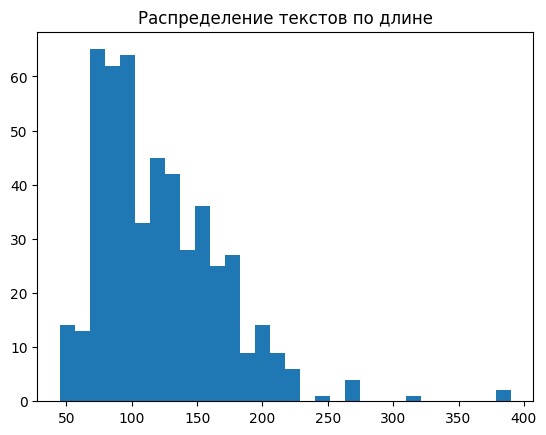

In [8]:
plt.title('Распределение текстов по длине')
plt.hist(list(map(len, token_texts)), bins=30)
plt.show()

## Функция для формирования топ-3 рекомендаций

Подготовим функцию, которая будет принимать в качестве аргументов:

- начальный массив данных
- векторизированную форму текстов
- порог похожести - минимальный уровень коэффициента косинусной близости для попадание в финальный датафрейм

В результате функция выведет датафрейм, который бдуте содержать средний уровень похожести для товара и топ-3 рекомендации с саммыми высокими индексами похожести. Дополнительно выводится график с распределением индексов по всем товарам.

Будем применять эту функцию для разных векторных представлений текстов и посмотрим какие подобрались похожие товары для артикулов c номером 200 (майка без рукавов, часто встречается) и номером 300 (женская короткая комбинация, довольно редкая). Так сможем оценить качество вектров при подборе.

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def sim_review(df, vectorized_texts, threshold):

    """In:
        df - initial dataframe,
        vectorized_texts - vectorized representation of the texts from dataframe,
        threshold - min level on cosine_similarity coefficient to be included in the review
      Out:
        Dataframe with title of the item and its description from the original dataframe,
        it's average similarity score based on the threshhold,
        top 3 most similar items
        Histplot with average scores similarity for all items in dataframe
    """

    res = pd.DataFrame()

    for item in range(len(df)):

        title = df.iloc[item]['description'].split('- ')[0]
        desc = df.iloc[item]['description']
        similarity = cosine_similarity(vectorized_texts[item], vectorized_texts).flatten()
        ind = np.argwhere(similarity > threshold)

        if ind.shape[0] <= 1:
            new_row = {'Title': title, 'Desc': desc, 'Avg_simil_score':0,
                'Top_1_rec': 'Not found', 'Top_2_rec': 'Not found', 'Top_3_rec': 'Not found'}
            res = res.append(new_row, ignore_index = True)
        else:
            scores = similarity[similarity > threshold]
            match = sorted(zip(scores, ind.tolist()), reverse=True)
            try:
                top_1 = round(match[1][0], 2).astype(str) + ' ' + df.iloc[match[1][1]]['description'].item()
            except:
                top_1 = 'None'
            try:
                top_2 = round(match[2][0], 2).astype(str) + ' ' + df.iloc[match[2][1]]['description'].item()
            except:
                top_2 = 'None'
            try:
                top_3 = round(match[3][0], 2).astype(str) + ' ' + df.iloc[match[3][1]]['description'].item()
            except:
                top_3 = 'None'
            avg_score = round((sum(i for i,j in match)-1)/(len(match)-1), 2)
            new_row = {'Title': title, 'Desc': desc, 'Avg_simil_score':avg_score,
                    'Top_1_rec': top_1, 'Top_2_rec': top_2, 'Top_3_rec': top_3}

            res = res.append(new_row, ignore_index = True)
    columns = ['Title', 'Desc', 'Avg_simil_score', 'Top_1_rec', 'Top_2_rec', 'Top_3_rec']

    res = res[columns]

    sns.histplot(res['Avg_simil_score'], bins = 30)
    plt.title(f"Avg_sim_score distribution, {round(len(res[res['Avg_simil_score'] == 0])/len(res)*100)}% with 0 score")
    plt.show()

    return res

## 2. Использование TfIdf векторов

При создании tfidf векторов попробуем разные парметры и оценим их влияние на результаты подбора похожих. Будем менять следующие параментры:

- min_df - параметр, ответсвенный за долю редких слов -> не используются слова с df ниже указанного порога. Попробуем величины 0.1 и 0.01
- max_df - параметр, ответсвенный за долю частотных слов -> не используюся слова выше указнного порога. Попробуем величины 0.75, 0.5 и default = 1
- ngram_range - границы для n-gram. Возъмем следующие параметры: (2, 3) - только биграммы и триграммы, (1, 3) - юни, би и триграммы

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(max_features = 250, norm = None,
                             tokenizer = lambda x:x,
                             min_df=0.1,
                             max_df = 0.75,
                             ngram_range=(2, 3),
                             lowercase=False)

vectorizer2 = TfidfVectorizer(max_features = 250, norm = None,
                             tokenizer = lambda x:x,
                             min_df=0.01,
                             max_df = 0.5,
                             ngram_range=(1, 3),
                             lowercase=False)
vectorizer3 = TfidfVectorizer(max_features = 250, norm = None,
                             tokenizer = lambda x:x,
                             min_df=0.01,
                             ngram_range=(1, 3),
                             lowercase=False)


### TfIdf min_df=0.1, max_df=0.75, ngram_range = (2,3)

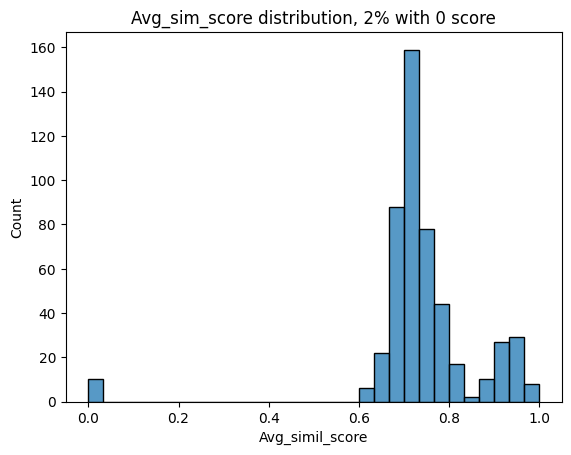

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
200,Merino 1 tank,"Merino 1 tank - Finespun and cool enough to lower the temperature of open trail runs, heated crags and the Laiki street market, this silky-soft yet highly durable jersey-knit tank is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding -invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck and armhole binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (60 g 2.1 oz)Made in USA.",0.800000,"0.9 Merino 1 t-shirt - So soft it's worth lingering in, our lightest merino layer is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, this silky yet highly durable jersey-knit offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: 73 g (2.6 oz)Made in USA.","0.9 Merino 1 graphic t-shirt - Feels as good as a laugh. Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around a an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness; 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand"" ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort So

In [11]:
rec = sim_review(df, vectorizer1.fit_transform(token_texts), threshold = 0.6)
rec[200:201].style

In [12]:
rec[300:301].style

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
300,Active classic cami,"Active classic cami - Worn under a dry top or as a base layer when topping 14,000 feet; the form-fitting Active Classic Cami will toe the line on any expedition. The 360-degree built-in shelf bra and adjustable shoulder straps won't slip or dig into your skin. The tank's supersoft nylon/spandex fabric blend (94%/6%) and seamless tube construction prevent chafing. Longer torso coverage pairs well with low-rise styles.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction ""360-degree shelf bra with adjustable, nonslip shoulder straps"" ""Appropriate length for pairing with low-rise style pants, shorts or skirts""Fabric: 4.6-oz 94% nylon/6% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel.",0.610000,"0.61 Print adour btm - Adours have a slightly scooped, low-rise front (lined) and medium coverage in back. Our improved fabric blend is made of 82% nylon/18% spandex.Details: Medium coverage Lined front Slightly scooping front Low rise Improved fabricFabric: 5.6-oz 82% nylon/18% spandexWeight: (43 g 1.5 oz)Made in USA.","0.61 Print sunamee btm - Stay-put Sunamees fit straight across the hips, with full coverage in back. Lined front. Made from a formfitting blend of 82% nylon/18% spandex.Details: Full coverage Lined front Fits straight across hips Regular rise Improved fabricFabric: 5.6-oz 82% nylon/18% spandexWeight: (43 g 1.5 oz)Made in USA.","0.61 Solid sunamee btm - Stay-put Sunamees fit straight across the hips, with full coverage in back. Lined front. Made from a formfitting blend of 82% nylon/18% spandex.Details: Full coverage Lined front Fits straight across hips Regular rise Improved fabricFabric: 5.6-oz 82% nylon/18% spandexWeight: (43 g 1.5 oz)Made in USA."


### TfIdf min_df=0.01, max_df=0.5, ngram_range = (1,3)

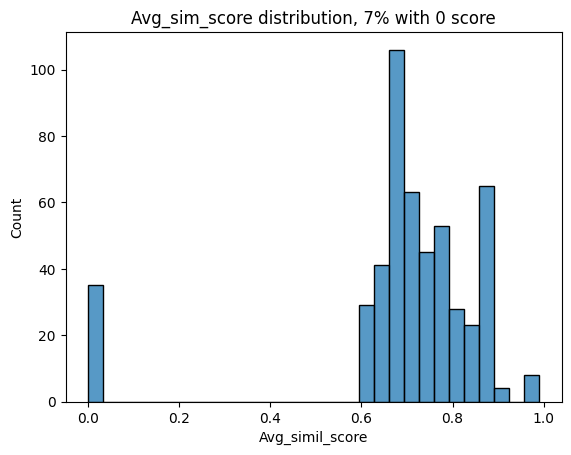

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
200,Merino 1 tank,"Merino 1 tank - Finespun and cool enough to lower the temperature of open trail runs, heated crags and the Laiki street market, this silky-soft yet highly durable jersey-knit tank is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding -invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck and armhole binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (60 g 2.1 oz)Made in USA.",0.830000,"0.98 Merino 1 t-shirt - So soft it's worth lingering in, our lightest merino layer is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, this silky yet highly durable jersey-knit offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: 73 g (2.6 oz)Made in USA.","0.98 Merino 1 crew - Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay fla

In [13]:
rec = sim_review(df, vectorizer2.fit_transform(token_texts), threshold = 0.6)
rec[200:201].style

In [14]:
rec[300:301].style

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
300,Active classic cami,"Active classic cami - Worn under a dry top or as a base layer when topping 14,000 feet; the form-fitting Active Classic Cami will toe the line on any expedition. The 360-degree built-in shelf bra and adjustable shoulder straps won't slip or dig into your skin. The tank's supersoft nylon/spandex fabric blend (94%/6%) and seamless tube construction prevent chafing. Longer torso coverage pairs well with low-rise styles.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction ""360-degree shelf bra with adjustable, nonslip shoulder straps"" ""Appropriate length for pairing with low-rise style pants, shorts or skirts""Fabric: 4.6-oz 94% nylon/6% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel.",0.610000,"0.61 Sport top - The loose, performance fit of the Women's Sport Top won't hike up or become annoyingly shifty during long-distance trail mileage. The extra-long, seamless racerback tank has a looser silhouette that increases airflow and eliminates hem migration. A comfortable built-in sports bra manages high impact activities; nylon/spandex (94%/6%) fabric blend provides moisture-wicking performance.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction 360-degree built-in sports bra ""Perfect length for pairing with running shorts, yoga pants or everyday styles""Fabric: Tank: 9.5-oz 94% nylon/6% spandex. Built-in sports bra: 9.5-oz 94% nylon/6% spandex. Both with moisture-wicking performanceWeight: 144 g (5.1 oz)Made in Israel.",None,None


### TfIdf min_df=0.01, max_df=1, ngram_range = (1,3)

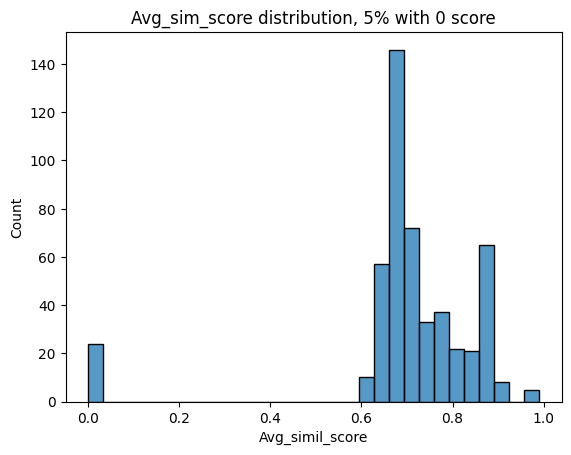

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
200,Merino 1 tank,"Merino 1 tank - Finespun and cool enough to lower the temperature of open trail runs, heated crags and the Laiki street market, this silky-soft yet highly durable jersey-knit tank is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding -invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck and armhole binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (60 g 2.1 oz)Made in USA.",0.900000,"0.98 Merino 1 t-shirt - So soft it's worth lingering in, our lightest merino layer is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, this silky yet highly durable jersey-knit offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: 73 g (2.6 oz)Made in USA.","0.98 Merino 1 crew - Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay fla

In [15]:
rec = sim_review(df, vectorizer3.fit_transform(token_texts), threshold = 0.6)
rec[200:201].style

In [16]:
rec[300:301].style

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
300,Active classic cami,"Active classic cami - Worn under a dry top or as a base layer when topping 14,000 feet; the form-fitting Active Classic Cami will toe the line on any expedition. The 360-degree built-in shelf bra and adjustable shoulder straps won't slip or dig into your skin. The tank's supersoft nylon/spandex fabric blend (94%/6%) and seamless tube construction prevent chafing. Longer torso coverage pairs well with low-rise styles.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction ""360-degree shelf bra with adjustable, nonslip shoulder straps"" ""Appropriate length for pairing with low-rise style pants, shorts or skirts""Fabric: 4.6-oz 94% nylon/6% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel.",0.660000,"0.66 Sport top - The loose, performance fit of the Women's Sport Top won't hike up or become annoyingly shifty during long-distance trail mileage. The extra-long, seamless racerback tank has a looser silhouette that increases airflow and eliminates hem migration. A comfortable built-in sports bra manages high impact activities; nylon/spandex (94%/6%) fabric blend provides moisture-wicking performance.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction 360-degree built-in sports bra ""Perfect length for pairing with running shorts, yoga pants or everyday styles""Fabric: Tank: 9.5-oz 94% nylon/6% spandex. Built-in sports bra: 9.5-oz 94% nylon/6% spandex. Both with moisture-wicking performanceWeight: 144 g (5.1 oz)Made in Israel.",None,None


### Выводы по результатам сравнения текстов с tfidf

Для векторов с ограничением на unigram и высоким min_df не нашлись похожие для редкой позиции - вместо маек были предложены шорты :(
Вектора без этого ограничения и с низким порогом для редких слов сработали лучше - был найден похожий топ (правда только 1).
При этом для менее уникального артикула модели с использованием всех векторов дали похожие результаты.



## 3. Использование word2vec векторов

Для формирования векторов текстов с использованием word2vec будем использовать среднее взвешенное каждого слова на веса из tfidf. Для вывода весов воспользумся инициированным на предыдущем шаге векторайзером. Посмотрим, также повиляет ли выбор обычного среднего арифметического на результат.

Посмотрим, как сработают вектора из 2-х вариантов:

- обучим Word2Vec на корпусах имеющихся текстов и с помоощью этой модели веторизуем описания
- воспользуемся готовой библиотекой https://huggingface.co/fse/word2vec-google-news-300

### Обучение word2vec на имеющемся корпусе текстов - взвешенный на tfidf

In [17]:
w_weights = dict(zip(vectorizer3.get_feature_names_out(), vectorizer3.idf_))

# ф-ция со средним взвешенным по tfidf

def text_vector(text, model):
    res = np.zeros(250)
    count = 0
    total_weights = 0
    for word in text:
        try:
            res += model.wv[word] *  w_weights[word]
            count += 1
            total_weights += w_weights[word]
        except:
            pass
    if count > 0:
        return res/total_weights
    else:
        return res

In [18]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(token_texts, window=5, min_count=1, vector_size=250, negative=5)

In [19]:
w2v_model.wv.most_similar('tank')

[('work', 0.9995627999305725),
 ('around', 0.9994348287582397),
 ('photo', 0.9994277358055115),
 ('year', 0.9993476271629333),
 ('world', 0.9991898536682129),
 ('barely', 0.9991891384124756),
 ('fishing', 0.999168336391449),
 ('live', 0.9991295337677002),
 ('sweater', 0.9989940524101257),
 ('little', 0.9989932179450989)]

In [20]:
w2v_model.wv.most_similar('cami')

[('trail', 0.9967429637908936),
 ('zone', 0.996718168258667),
 ('enough', 0.9966863989830017),
 ('pant', 0.9966512322425842),
 ('mountain', 0.996638298034668),
 ('day', 0.9966188073158264),
 ('wader', 0.9965829849243164),
 ('midsole', 0.9965746402740479),
 ('climb', 0.9965537190437317),
 ('sport', 0.9965531826019287)]

In [21]:
from tqdm import tqdm_notebook
from scipy import sparse
texts_w_mean_vect = [text_vector(text, w2v_model) for text in tqdm_notebook(token_texts)]
np_texts_mean_vect = np.vstack(texts_w_mean_vect)
w2v_vec= sparse.csr_matrix(np_texts_mean_vect)

  0%|          | 0/500 [00:00<?, ?it/s]

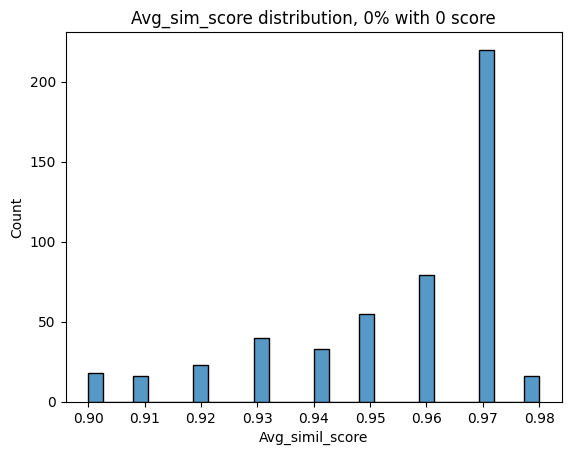

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
200,Merino 1 tank,"Merino 1 tank - Finespun and cool enough to lower the temperature of open trail runs, heated crags and the Laiki street market, this silky-soft yet highly durable jersey-knit tank is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding -invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck and armhole binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (60 g 2.1 oz)Made in USA.",0.970000,"1.0 Merino 1 t-shirt - So soft it's worth lingering in, our lightest merino layer is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, this silky yet highly durable jersey-knit offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: 73 g (2.6 oz)Made in USA.","1.0 Merino 1 crew - Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat 

In [22]:
rec = sim_review(df, w2v_vec, threshold = 0.6)
rec[200:201].style

In [23]:
rec[300:301].style

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
300,Active classic cami,"Active classic cami - Worn under a dry top or as a base layer when topping 14,000 feet; the form-fitting Active Classic Cami will toe the line on any expedition. The 360-degree built-in shelf bra and adjustable shoulder straps won't slip or dig into your skin. The tank's supersoft nylon/spandex fabric blend (94%/6%) and seamless tube construction prevent chafing. Longer torso coverage pairs well with low-rise styles.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction ""360-degree shelf bra with adjustable, nonslip shoulder straps"" ""Appropriate length for pairing with low-rise style pants, shorts or skirts""Fabric: 4.6-oz 94% nylon/6% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel.",0.970000,"1.0 Active boy shorts - We've worn these versatile, feminine boy shorts as on-the-fly bathing suit bottoms, to Bikram yoga class, as sleepwear - their functionality is limitless. Low-rise Active Boy Shorts are tube-constructed to eliminate chafing side seams, and their soft, technical fabric breathes and wicks moisture to keep you comfortable and dry. We've shortened the flat waistband in front for a fit that won't roll or bind; stretchy shaped openings at legs are newly redesigned with less fabric to minimize bunching. Solids and prints: 4.6-oz 93% nylon/7% spandex.Details: ""Ultrasoft, lightweight fabric with stretch and moisture management"" Seamless construction ""Waistband and shaped leg openings lie flat, won't roll or bind for well deserved comfort and mobility""Fabric: ""4.6-oz 93% nylon/7% spandex, with moisture-wicking performance""Weight: (31 g 1.1 oz)Made in Israel.","1.0 Corinne dress - After a day of Rivermouth's glassy offshore, slide on the Corinne Dress for shrimp tacos at the harbor. Featuring a deep V-neck with wide straps, the dress has an effortless drape, and is made from stretchy, quick-dry fabric (86% nylon/14% spandex) for an active disposition. A supportive double bodice with flattering shirred detail uplifts; front panel inset helps with contouring. Hem falls above the knee.Details: ""Stretchy, soft, synthetic jersey knit"" Wide straps and flattering V-front detail Supportive double bodice with shirring for shaping Front panel inset for contouring Hem falls above the kneeFabric: 7-oz 86% nylon/14% spandex smooth-faced jersey knit with moisture-wicking performanceWeight: (311 g 10.8 oz)Made in Colombia.","1.0 Active mesh bra - Despite its inability to act as a belay slave, our Active Mesh Bra makes a perfect climbing partner. The body-conforming fabric provides fluid support and wicks moisture, while the seamless construction eliminates chafing. Comfortable nonslip straps won't dig into skin; they contour to a flattering V in back for unobstructed movement. The full-coverage design can go solo, or partner with layers. Made from 95% nylon mesh/5% spandex.Details: ""Stretchy, body-conforming nylon/spandex blend is ultradurable, supportive and wicks moisture to keep skin dry"" Seamless construction ""Comfortable, nonslip straps meet V-style in back""Fabric: 8.1-oz 95% nylon mesh/5% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel."


### Использование готовой модели - взвешенный на tfidf

In [24]:
import gensim
import gensim.downloader

w2v_ready = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Немного поменяем функцию, так как готовые модели не используют wv:

In [25]:
def text_vector(text, model):
    res = np.zeros(300)
    count = 0
    total_weights = 0
    for word in text:
        try:
            res += model[word] *  w_weights[word]
            count += 1
            total_weights += w_weights[word]
        except:
            pass
    if count > 0:
        return res/total_weights
    else:
        return res

In [26]:
from tqdm import tqdm_notebook
texts_w_mean_vect = [text_vector(text, w2v_ready) for text in tqdm_notebook(token_texts)]
np_texts_mean_vect = np.vstack(texts_w_mean_vect)
w2v_vec2 = sparse.csr_matrix(np_texts_mean_vect)

  0%|          | 0/500 [00:00<?, ?it/s]

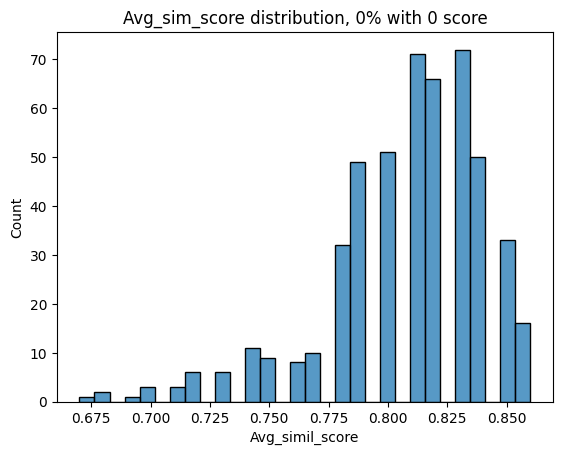

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
200,Merino 1 tank,"Merino 1 tank - Finespun and cool enough to lower the temperature of open trail runs, heated crags and the Laiki street market, this silky-soft yet highly durable jersey-knit tank is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding -invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck and armhole binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (60 g 2.1 oz)Made in USA.",0.780000,"1.0 Merino 1 crew - Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (95 g 3.3 oz)Made in USA.","1.0 Merino 1 t-shirt - So soft it's worth lingering in, our lightest merino layer is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, this silky yet highly durable jersey-knit offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat 

In [27]:
rec = sim_review(df, w2v_vec2, threshold = 0.6)
rec[200:201].style

In [28]:
rec[300:301].style

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
300,Active classic cami,"Active classic cami - Worn under a dry top or as a base layer when topping 14,000 feet; the form-fitting Active Classic Cami will toe the line on any expedition. The 360-degree built-in shelf bra and adjustable shoulder straps won't slip or dig into your skin. The tank's supersoft nylon/spandex fabric blend (94%/6%) and seamless tube construction prevent chafing. Longer torso coverage pairs well with low-rise styles.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction ""360-degree shelf bra with adjustable, nonslip shoulder straps"" ""Appropriate length for pairing with low-rise style pants, shorts or skirts""Fabric: 4.6-oz 94% nylon/6% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel.",0.820000,"0.94 Sport top - The loose, performance fit of the Women's Sport Top won't hike up or become annoyingly shifty during long-distance trail mileage. The extra-long, seamless racerback tank has a looser silhouette that increases airflow and eliminates hem migration. A comfortable built-in sports bra manages high impact activities; nylon/spandex (94%/6%) fabric blend provides moisture-wicking performance.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction 360-degree built-in sports bra ""Perfect length for pairing with running shorts, yoga pants or everyday styles""Fabric: Tank: 9.5-oz 94% nylon/6% spandex. Built-in sports bra: 9.5-oz 94% nylon/6% spandex. Both with moisture-wicking performanceWeight: 144 g (5.1 oz)Made in Israel.","0.91 Morning glory tights - This everyday essential features a clean-cut design in a stretch knit with excellent shape retention. The soft, substantial nylon blend (86% nylon/14% spandex) flows lightly over skin and dries quickly after a humid hike or passing squall. We've added topstitch detailing and a more contoured fit this season. The wide, low-rise waist provides chafe-free comfort. Inseam (size M) is 32"".Details: ""Substantial, ultra-stretchy and soft synthetic knit with excellent shape retention; wicks moisture and dries fast"" ""Flattering, wide, flat waistband"" ""Curved back-yoke detailing and asymmetric side seams, contoured fit through thigh, slight flare at hem"" Flat-seam construction is soft against skin Low rise ""Inseam (size M) is 32""""""Fabric: 7-oz 86% nylon/14% spandex smooth-faced jersey knit with moisture-wicking performanceWeight: (271 g 9.4 oz)Made in Colombia.","0.91 Active mesh bra - Despite its inability to act as a belay slave, our Active Mesh Bra makes a perfect climbing partner. The body-conforming fabric provides fluid support and wicks moisture, while the seamless construction eliminates chafing. Comfortable nonslip straps won't dig into skin; they contour to a flattering V in back for unobstructed movement. The full-coverage design can go solo, or partner with layers. Made from 95% nylon mesh/5% spandex.Details: ""Stretchy, body-conforming nylon/spandex blend is ultradurable, supportive and wicks moisture to keep skin dry"" Seamless construction ""Comfortable, nonslip straps meet V-style in back""Fabric: 8.1-oz 95% nylon mesh/5% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel."


### Обучение word2vec на имеющемся корпусе текстов - средний арифметический

Обновим немного функцию для использования среднего арифметического

In [29]:
import numpy as np
# ф-ция для обычного среднего
def vectorize(words):
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(250)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [30]:
w2vec2 = np.array([vectorize(sentence) for sentence in token_texts])
w2v_vec2= sparse.csr_matrix(w2vec2)

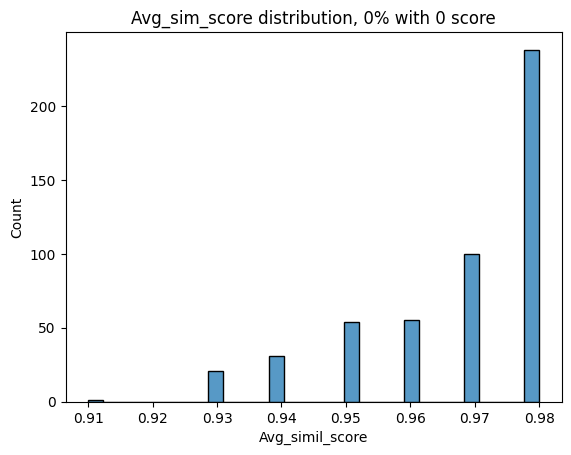

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
200,Merino 1 tank,"Merino 1 tank - Finespun and cool enough to lower the temperature of open trail runs, heated crags and the Laiki street market, this silky-soft yet highly durable jersey-knit tank is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding -invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck and armhole binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (60 g 2.1 oz)Made in USA.",0.980000,"1.0 Merino 1 graphic t-shirt - Feels as good as a laugh. Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around a an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness; 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand"" ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Soft graphic print doesn't impede performance Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: 73 g (2.6 oz)Made in USA.","1.0 Merino 2 bottoms - A stop-and-go pace, like that of alpine climbing or backcountry riding, can leave you with the shivers. These lightweight bottoms will help you stay dry and warm. Our most versatile merino layer for an active lifestyle in warm to cool weather, Merino 2 is made with 73% merino wool spun around an all-recycled polyester (27%) core for a luxurious hand, an improved dry time and enduring strength. Inherently soft and comfortable, merino naturally resists odor, moves moisture away from the skin, regulates body temperature, and stretches. Details include a brushed-elastic waistband, offset inseams and a functional fly. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable and stretches, provides superior performance and softness"" 18.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next 

In [31]:
rec = sim_review(df, w2v_vec2, threshold = 0.6)
rec[200:201].style

In [32]:
rec[300:301].style

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
300,Active classic cami,"Active classic cami - Worn under a dry top or as a base layer when topping 14,000 feet; the form-fitting Active Classic Cami will toe the line on any expedition. The 360-degree built-in shelf bra and adjustable shoulder straps won't slip or dig into your skin. The tank's supersoft nylon/spandex fabric blend (94%/6%) and seamless tube construction prevent chafing. Longer torso coverage pairs well with low-rise styles.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction ""360-degree shelf bra with adjustable, nonslip shoulder straps"" ""Appropriate length for pairing with low-rise style pants, shorts or skirts""Fabric: 4.6-oz 94% nylon/6% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel.",0.980000,"1.0 Active boy shorts - We've worn these versatile, feminine boy shorts as on-the-fly bathing suit bottoms, to Bikram yoga class, as sleepwear - their functionality is limitless. Low-rise Active Boy Shorts are tube-constructed to eliminate chafing side seams, and their soft, technical fabric breathes and wicks moisture to keep you comfortable and dry. We've shortened the flat waistband in front for a fit that won't roll or bind; stretchy shaped openings at legs are newly redesigned with less fabric to minimize bunching. Solids and prints: 4.6-oz 93% nylon/7% spandex.Details: ""Ultrasoft, lightweight fabric with stretch and moisture management"" Seamless construction ""Waistband and shaped leg openings lie flat, won't roll or bind for well deserved comfort and mobility""Fabric: ""4.6-oz 93% nylon/7% spandex, with moisture-wicking performance""Weight: (31 g 1.1 oz)Made in Israel.","1.0 Girl's t-back one piece - A girl's trusted companion for Sunfish races, seashell collecting and learning to swan dive, this one-piece bathing suit features an easy-care blend of stretchy 6-oz 82% nylon/18% spandex to match the ebb and flow of her beach activities. It withstands exposure to sun, salt water and chlorine, and dries quickly. Racerback straps allow complete shoulder mobility; they stay put when arms start flying. Contrast binding on the straps and leg openings feels smooth against bare skin.Details: Racerback straps for comfort and extra mobility Contrast binding on leg openings and strapsFabric: 6-oz 82% nylon/18% spandexWeight: (83 g 2.9 oz)Made in USA.","1.0 Corinne dress - After a day of Rivermouth's glassy offshore, slide on the Corinne Dress for shrimp tacos at the harbor. Featuring a deep V-neck with wide straps, the dress has an effortless drape, and is made from stretchy, quick-dry fabric (86% nylon/14% spandex) for an active disposition. A supportive double bodice with flattering shirred detail uplifts; front panel inset helps with contouring. Hem falls above the knee.Details: ""Stretchy, soft, synthetic jersey knit"" Wide straps and flattering V-front detail Supportive double bodice with shirring for shaping Front panel inset for contouring Hem falls above the kneeFabric: 7-oz 86% nylon/14% spandex smooth-faced jersey knit with moisture-wicking performanceWeight: (311 g 10.8 oz)Made in Colombia."


### Выводы по результатам сравнения текстов с word2vec:

Вектора из готовой модели сработали лучше для редкого артикула, из 3-х топовых рекомендаций две касаются верхней части одежды, ошибся только на 2-м - посоветовал штаны.

Сравнение на основе векторов, обученных на имеющемся корпусе текстов, дали немного странные результаты и по общим уровням похожести. Выбор варианта арифметического среднего vs среднего, взвешенного по tfidf, для формирования вектора предложения тоже не дал особой разницы. Для редкого артикула майки похожими оказались шорты для мальчика, цельный купальник для девочки и платье :(


## 4. Использование LaBSE векторов
Конечно я не могла обойти стороной вектора на основе трансформенных моделей и сравнить результат с предыдущими и с точки зрения затраченных усилий, и конечных рекомендаций.

В качестве экперимента не буду совсем чистить текст, а возьму начальный со всеми странными знаками.

In [33]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=ec8501c7bafb9ab373a3ceea93ce3b75df82f317eb50ccaef4e2f951bf395af3
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [35]:
from sentence_transformers import SentenceTransformer
sentences = df['description'].tolist()

model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = model.encode(sentences, normalize_embeddings=True)
embeddings.shape

(500, 768)

In [36]:
emb= sparse.csr_matrix(embeddings)

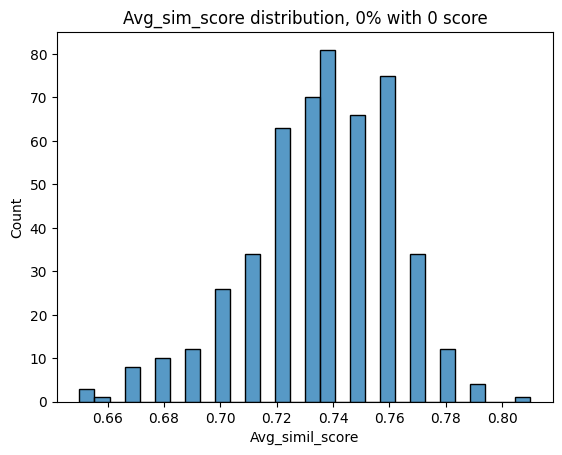

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
200,Merino 1 tank,"Merino 1 tank - Finespun and cool enough to lower the temperature of open trail runs, heated crags and the Laiki street market, this silky-soft yet highly durable jersey-knit tank is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding -invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck and armhole binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: (60 g 2.1 oz)Made in USA.",0.710000,"0.97 Merino 1 t-shirt - So soft it's worth lingering in, our lightest merino layer is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, this silky yet highly durable jersey-knit offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay flat to dry""Fabric: 3.2-oz (108-g) 63% 16.5 micron chlorine-free merino wool/37% all-recycled polyester. Recyclable through the Common Threads Recycling ProgramWeight: 73 g (2.6 oz)Made in USA.","0.97 Merino 1 crew - Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.Details: ""Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness"" 16.5 micron-gauge yarn and jersey-knit construction for luxurious hand ""All-recycled polyester core wicks moisture, while wool next to skin controls odor"" Softly scooped neckline ventilates while still covering bra Self-fabric neck binding for comfort Straight hem ""Machine-wash cold, lay fla

In [37]:
rec = sim_review(df, emb, threshold = 0.6)
rec[200:201].style

In [38]:
rec[300:301].style

,Title,Desc,Avg_simil_score,Top_1_rec,Top_2_rec,Top_3_rec
300,Active classic cami,"Active classic cami - Worn under a dry top or as a base layer when topping 14,000 feet; the form-fitting Active Classic Cami will toe the line on any expedition. The 360-degree built-in shelf bra and adjustable shoulder straps won't slip or dig into your skin. The tank's supersoft nylon/spandex fabric blend (94%/6%) and seamless tube construction prevent chafing. Longer torso coverage pairs well with low-rise styles.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction ""360-degree shelf bra with adjustable, nonslip shoulder straps"" ""Appropriate length for pairing with low-rise style pants, shorts or skirts""Fabric: 4.6-oz 94% nylon/6% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel.",0.730000,"0.9 Sport top - The loose, performance fit of the Women's Sport Top won't hike up or become annoyingly shifty during long-distance trail mileage. The extra-long, seamless racerback tank has a looser silhouette that increases airflow and eliminates hem migration. A comfortable built-in sports bra manages high impact activities; nylon/spandex (94%/6%) fabric blend provides moisture-wicking performance.Details: Supersoft nylon/spandex blend for next-to-skin comfort Seamless construction 360-degree built-in sports bra ""Perfect length for pairing with running shorts, yoga pants or everyday styles""Fabric: Tank: 9.5-oz 94% nylon/6% spandex. Built-in sports bra: 9.5-oz 94% nylon/6% spandex. Both with moisture-wicking performanceWeight: 144 g (5.1 oz)Made in Israel.","0.88 Active briefs - Whether you're beating the heat in Bali or skinning up your favorite cirque, these ultrasoft, lightweight briefs provide exceptional stretch and moisture-management for keeping you comfortable and dry. They also glide easily beneath layers. A seamless waistband lies flat and won't roll or bind; newly redesigned single-sided leg binding stays put and is low-profile. With a breathable mini-rib crotch. Solids and prints: 4.6-oz 96% nylon/4% spandex. Stripes: 5.6-oz 93% polyester (58% recycled)/7% spandex.Details: ""Ultrasoft, lightweight fabric with stretch and moisture management"" ""Seamless waistband lies flat, won't roll or bind, breathable mini-rib crotch, soft, single-sided binding at leg openings wont chafe or creep""Fabric: Solids and prints: 4.6-oz 96% nylon/4% spandex. Stripes: 5.6-oz 94% polyester (58% recycled)/7% spandex. All with moisture-wicking performanceWeight: (28 g 1 oz)Made in Israel.","0.86 Active mesh bra - Despite its inability to act as a belay slave, our Active Mesh Bra makes a perfect climbing partner. The body-conforming fabric provides fluid support and wicks moisture, while the seamless construction eliminates chafing. Comfortable nonslip straps won't dig into skin; they contour to a flattering V in back for unobstructed movement. The full-coverage design can go solo, or partner with layers. Made from 95% nylon mesh/5% spandex.Details: ""Stretchy, body-conforming nylon/spandex blend is ultradurable, supportive and wicks moisture to keep skin dry"" Seamless construction ""Comfortable, nonslip straps meet V-style in back""Fabric: 8.1-oz 95% nylon mesh/5% spandex with moisture-wicking performanceWeight: (72 g 2.5 oz)Made in Israel."


# Финальные выводы

Вектора на основе Labse сработали быстрее всего на основе исходных текстов без обработки. Результаты сравнимы с готовой библиотекой word2vec и лучше, чем вариант tfidf при Min_df = 0.01 + ngram_range = (1,3).